In [1]:
!pip install --quiet vit-keras
!pip install tensorflow_addons

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 5.3 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Using our merged dataset (train & val), alongside our given test data

This Task is task 2 (SEB VS NEVUS AND MEL) - TASK 2

In [3]:
#Set title for saving model
title = "seb_vs_nev&mel_aug"

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import pandas as pd
import numpy as np
import keras
from keras import backend as K

import tensorflow
from tensorflow.keras.layers import Dropout, Dense, LayerNormalization, Flatten
from tensorflow.keras.activations import gelu
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from vit_keras import vit
import tensorflow_addons as tfa
import math

import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt

from zipfile import ZipFile
import time
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.metrics import roc_auc_score
from sklearn.metrics import  precision_score, recall_score, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import backend as K

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [6]:
os.listdir('/content')

['.config', 'drive', 'sample_data']

In [7]:
#Initialize the ViT model
vit_model = vit.vit_b16(
        image_size = 224,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 2)

347502902/347502902 [==============================] - 5s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


In [8]:
#Adding additional layers on top of ViT model
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(11, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(2, 'softmax')
    ],
    name = 'vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 batch_normalization (BatchN  (None, 768)              3072      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 11)                8459      
                                                                 
 batch_normalization_1 (Batc  (None, 11)               44        
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 2)          

In [9]:
#Compiling model using binary cross entropy and adam optimizer
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [10]:
early_stopping = EarlyStopping(monitor='val_loss',patience=2)               #Configuring early stopping criteria

def step_decay(epoch):
    initial_lrate = 0.00002                                                 #Configuring learning rate
    drop = 0.1
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))       #Configuring epoch drop
    return lrate

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(step_decay, verbose=1)

In [11]:
def graph_it(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Model Accuracy: Training and Validation')
  plt.legend(loc=0)
  plt.figure()

  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation Loss')
  plt.legend(loc=0)
  plt.figure()


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report, precision_score, roc_curve, ConfusionMatrixDisplay

def test_it(model, test_generator):
    test_labels = test_generator.classes

    predictions = model.predict(test_generator)
    predicted_labels = np.argmax(predictions, axis=1)

    cm = confusion_matrix(test_labels, predicted_labels)            #Confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    roc = roc_auc_score(test_labels, predictions[:, 1])  # ROC score calculation

    # Calculate confusion matrix 
    tn, fp, fn, tp = confusion_matrix(test_labels, predicted_labels).ravel()

    # Calculate sensitivity and specificity
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    report = classification_report(test_labels, predicted_labels)       #Classification report

    precision = precision_score(test_labels, predicted_labels, average='weighted')      #Calculating precision score

    print("\n", report)
    print(f"Sensitivity: {round(sensitivity, 3)} Specificity: {round(specificity, 3)} Precision: {round(precision, 3)} ROC_AUC_SCORE: {round(roc, 3)}\n")

    # Plot AUC-ROC curve
    fpr, tpr, thresholds = roc_curve(test_labels, predictions[:, 1])
    plt.figure(figsize=(4, 4))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc)
    plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [13]:
# Set the directories for the data for task1 (MEL VS NEVUS AND SEB)
train_dir = "/content/drive/MyDrive/msc_project/train_merged_augumented/task2"
test_dir = "/content/drive/MyDrive/msc_project/test/task2"

In [14]:
# Combine the paths and corresponding labels for the stratified k-fold
train_paths = []
train_labels = []
for class_folder in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_folder)
    if os.path.isdir(class_path):
        class_label = class_folder
        for image_filename in os.listdir(class_path):
            train_paths.append(os.path.join(class_path, image_filename))
            train_labels.append(class_label)

train_paths = np.array(train_paths)
train_labels = np.array(train_labels)

In [15]:
# Define the data generator
datagen = ImageDataGenerator(
    preprocessing_function= \
    tensorflow.keras.applications.mobilenet.preprocess_input)

image_size = (224, 224)
batch = 10
num_fold = 5

# Initialize the stratified k-fold object
skf = StratifiedKFold(n_splits=num_fold, shuffle=False, random_state=None)

In [16]:
model_path = f'/content/drive/MyDrive/msc_project/model/{title}'
os.makedirs(model_path, exist_ok=True)

Traning for Fold: 1
Found 10320 validated image filenames belonging to 2 classes.
Found 2580 validated image filenames belonging to 2 classes.
Found 2580 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/10
104/104 [==============================] - ETA: 0s - loss: 0.7498 - accuracy: 0.5500
Epoch 1: val_accuracy improved from -inf to 0.69615, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev&mel_aug/model_fold_1.hdf5
104/104 [==============================] - 271s 2s/step - loss: 0.7498 - accuracy: 0.5500 - val_loss: 0.6267 - val_accuracy: 0.6962 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/10
104/104 [==============================] - ETA: 0s - loss: 0.6807 - accuracy: 0.6192
Epoch 2: val_accuracy did not improve from 0.69615
104/104 [==============================] - 58s 557ms/step - loss: 0.6807 - accuracy: 0.6192 - val_loss: 0.7557 - val_accuracy: 0.

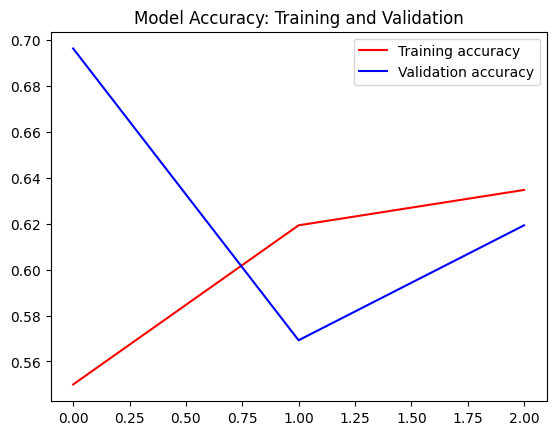

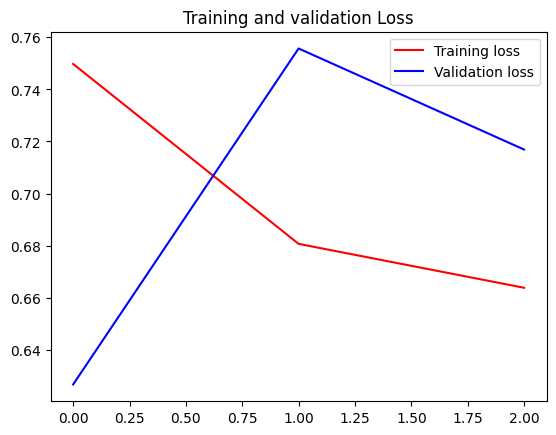

<Figure size 640x480 with 0 Axes>

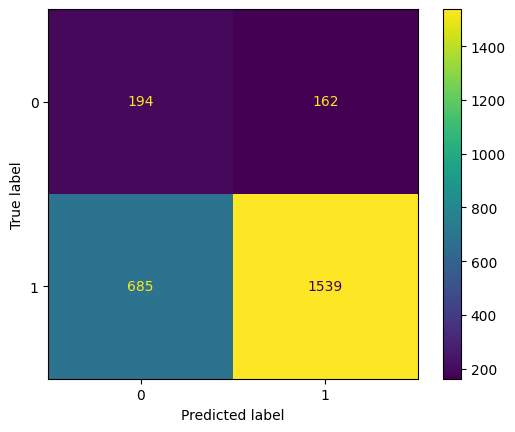


               precision    recall  f1-score   support

           0       0.22      0.54      0.31       356
           1       0.90      0.69      0.78      2224

    accuracy                           0.67      2580
   macro avg       0.56      0.62      0.55      2580
weighted avg       0.81      0.67      0.72      2580

Sensitivity: 0.692 Specificity: 0.545 Precision: 0.81 ROC_AUC_SCORE: 0.651



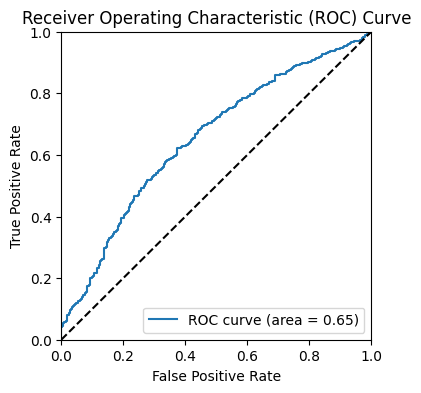

Validation complete...
Traning for Fold: 2
Found 10320 validated image filenames belonging to 2 classes.
Found 2580 validated image filenames belonging to 2 classes.
Found 2580 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/10
104/104 [==============================] - ETA: 0s - loss: 0.7002 - accuracy: 0.5942
Epoch 1: val_accuracy improved from -inf to 0.87692, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev&mel_aug/model_fold_2.hdf5
104/104 [==============================] - 110s 566ms/step - loss: 0.7002 - accuracy: 0.5942 - val_loss: 0.3732 - val_accuracy: 0.8769 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/10
104/104 [==============================] - ETA: 0s - loss: 0.6708 - accuracy: 0.6337
Epoch 2: val_accuracy did not improve from 0.87692
104/104 [==============================] - 55s 529ms/step - loss: 0.6708 - accuracy: 0.6337 - val_loss:

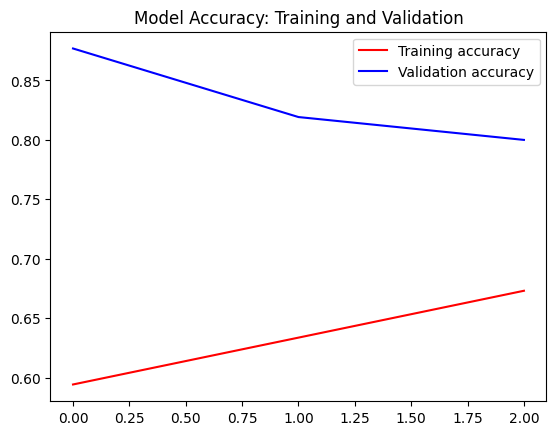

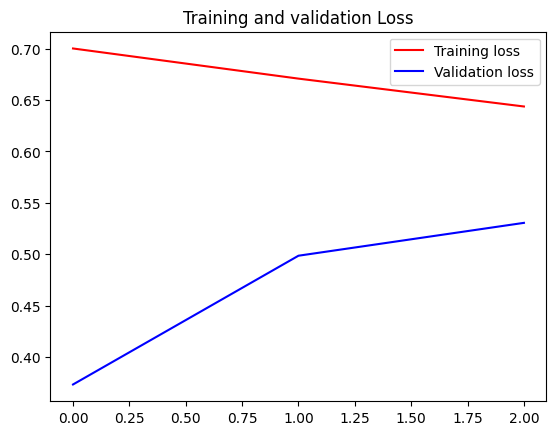

<Figure size 640x480 with 0 Axes>

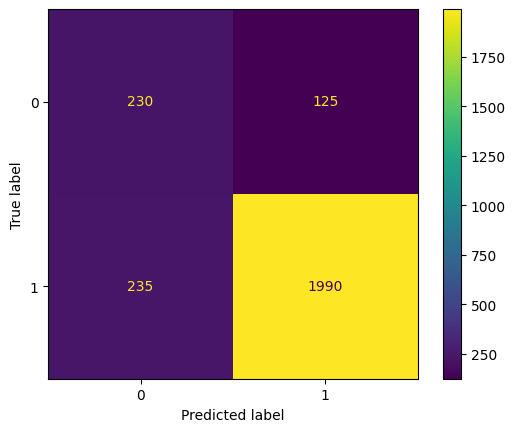


               precision    recall  f1-score   support

           0       0.49      0.65      0.56       355
           1       0.94      0.89      0.92      2225

    accuracy                           0.86      2580
   macro avg       0.72      0.77      0.74      2580
weighted avg       0.88      0.86      0.87      2580

Sensitivity: 0.894 Specificity: 0.648 Precision: 0.879 ROC_AUC_SCORE: 0.878



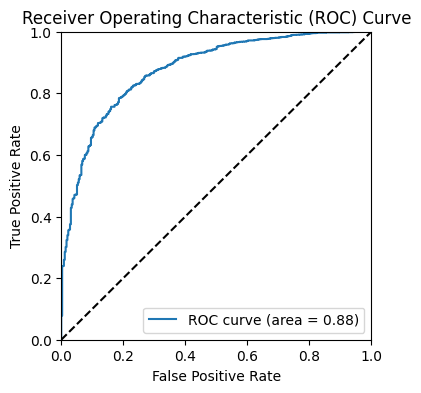

Validation complete...
Traning for Fold: 3
Found 10320 validated image filenames belonging to 2 classes.
Found 2580 validated image filenames belonging to 2 classes.
Found 2580 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/10
104/104 [==============================] - ETA: 0s - loss: 0.6643 - accuracy: 0.6394
Epoch 1: val_accuracy improved from -inf to 0.83846, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev&mel_aug/model_fold_3.hdf5
104/104 [==============================] - 117s 525ms/step - loss: 0.6643 - accuracy: 0.6394 - val_loss: 0.5045 - val_accuracy: 0.8385 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/10
104/104 [==============================] - ETA: 0s - loss: 0.6023 - accuracy: 0.7087
Epoch 2: val_accuracy improved from 0.83846 to 0.90000, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev&mel_aug/model_fold_3.hdf5
104/

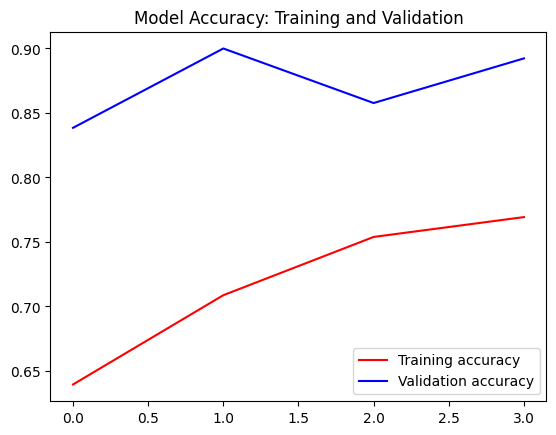

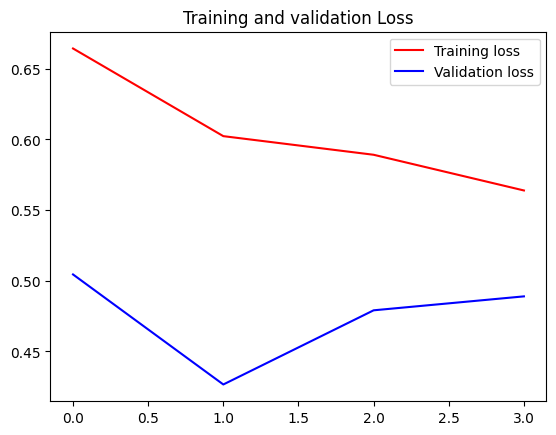

<Figure size 640x480 with 0 Axes>

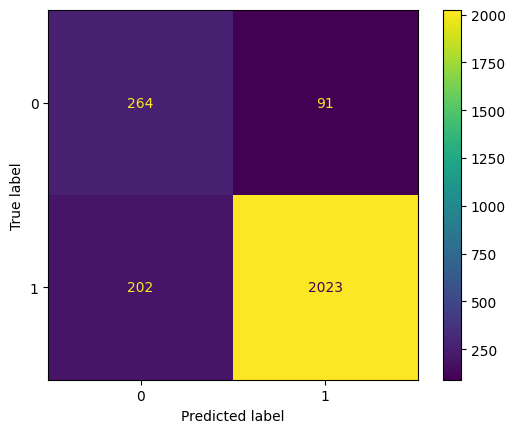


               precision    recall  f1-score   support

           0       0.57      0.74      0.64       355
           1       0.96      0.91      0.93      2225

    accuracy                           0.89      2580
   macro avg       0.76      0.83      0.79      2580
weighted avg       0.90      0.89      0.89      2580

Sensitivity: 0.909 Specificity: 0.744 Precision: 0.903 ROC_AUC_SCORE: 0.888



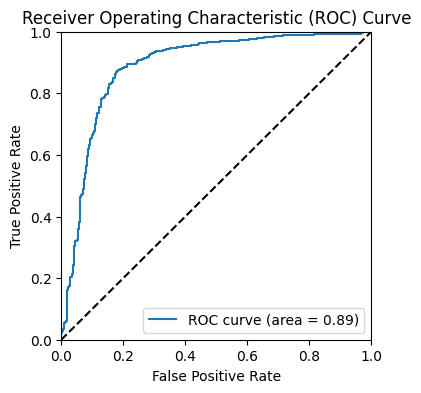

Validation complete...
Traning for Fold: 4
Found 10320 validated image filenames belonging to 2 classes.
Found 2580 validated image filenames belonging to 2 classes.
Found 2580 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/10
104/104 [==============================] - ETA: 0s - loss: 0.6298 - accuracy: 0.7135
Epoch 1: val_accuracy improved from -inf to 0.88462, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev&mel_aug/model_fold_4.hdf5
104/104 [==============================] - 114s 580ms/step - loss: 0.6298 - accuracy: 0.7135 - val_loss: 0.4806 - val_accuracy: 0.8846 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/10
104/104 [==============================] - ETA: 0s - loss: 0.6088 - accuracy: 0.7183
Epoch 2: val_accuracy improved from 0.88462 to 0.89615, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev&mel_aug/model_fold_4.hdf5
104/

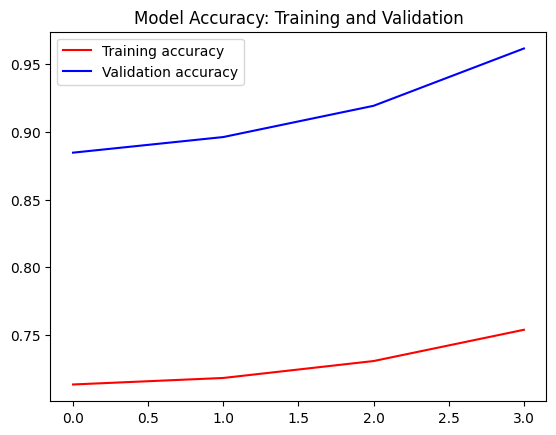

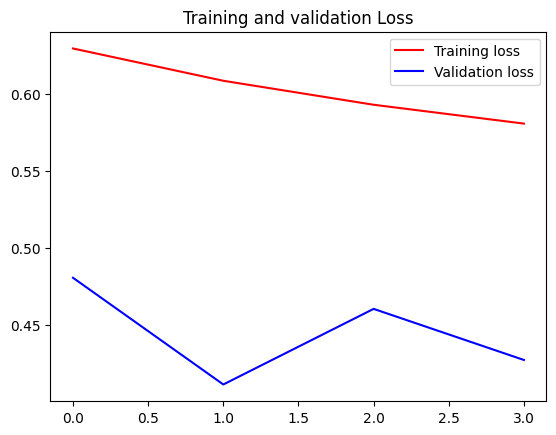

<Figure size 640x480 with 0 Axes>

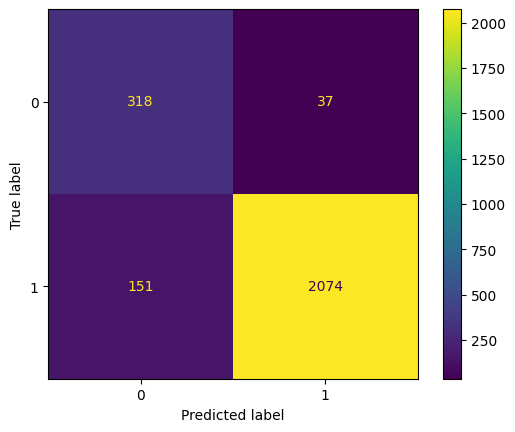


               precision    recall  f1-score   support

           0       0.68      0.90      0.77       355
           1       0.98      0.93      0.96      2225

    accuracy                           0.93      2580
   macro avg       0.83      0.91      0.86      2580
weighted avg       0.94      0.93      0.93      2580

Sensitivity: 0.932 Specificity: 0.896 Precision: 0.941 ROC_AUC_SCORE: 0.969



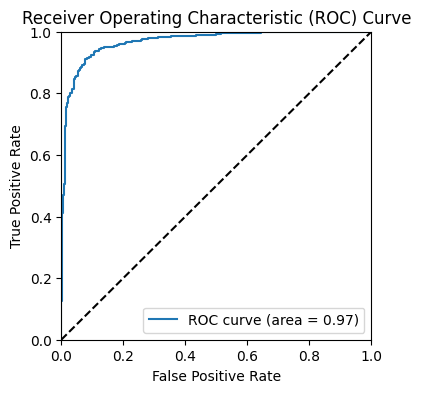

Validation complete...
Traning for Fold: 5
Found 10320 validated image filenames belonging to 2 classes.
Found 2580 validated image filenames belonging to 2 classes.
Found 2580 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/10
104/104 [==============================] - ETA: 0s - loss: 0.5562 - accuracy: 0.7837
Epoch 1: val_accuracy improved from -inf to 0.90000, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev&mel_aug/model_fold_5.hdf5
104/104 [==============================] - 110s 537ms/step - loss: 0.5562 - accuracy: 0.7837 - val_loss: 0.4624 - val_accuracy: 0.9000 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/10
104/104 [==============================] - ETA: 0s - loss: 0.5224 - accuracy: 0.8250
Epoch 2: val_accuracy improved from 0.90000 to 0.93077, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev&mel_aug/model_fold_5.hdf5
104/

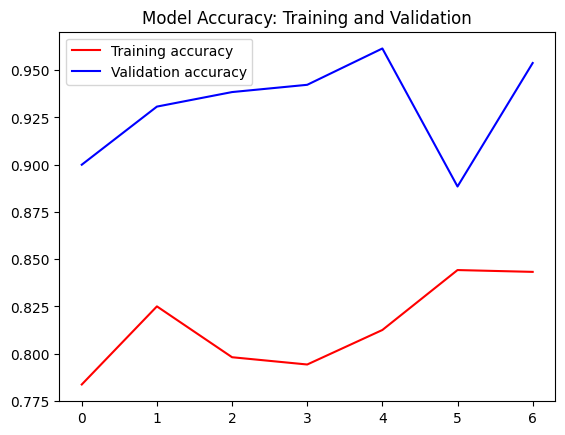

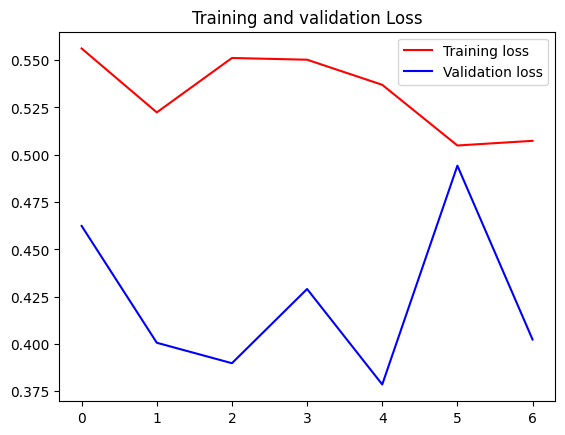

<Figure size 640x480 with 0 Axes>

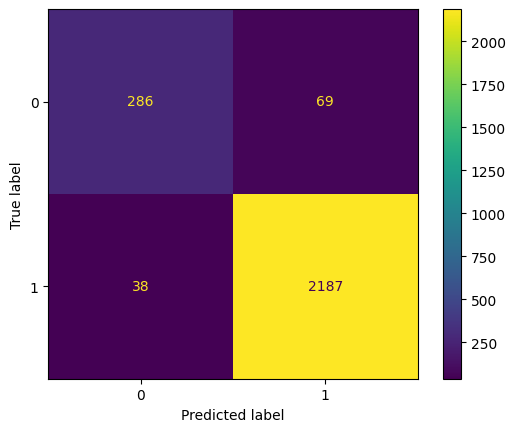


               precision    recall  f1-score   support

           0       0.88      0.81      0.84       355
           1       0.97      0.98      0.98      2225

    accuracy                           0.96      2580
   macro avg       0.93      0.89      0.91      2580
weighted avg       0.96      0.96      0.96      2580

Sensitivity: 0.983 Specificity: 0.806 Precision: 0.957 ROC_AUC_SCORE: 0.961



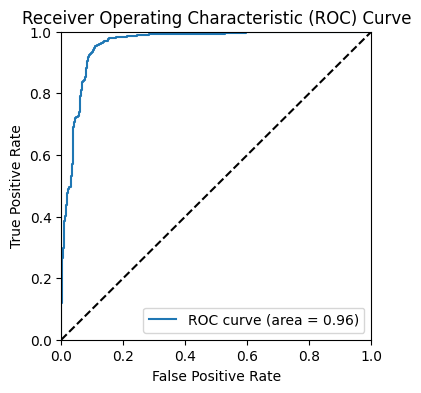

Validation complete...


In [17]:
# Perform k-fold cross-validation
fold = 1
for i, (train_index, val_index) in enumerate(skf.split(train_paths, train_labels)):
#     print(f"Fold {i}:")
    print(f"Traning for Fold: {fold}")
    # Split the data into train and validation sets for this fold
    train_paths_fold, val_paths_fold = train_paths[train_index], train_paths[val_index]
    train_labels_fold, val_labels_fold = train_labels[train_index], train_labels[val_index]

    # Create data generators for this fold
    train_generator_fold = datagen.flow_from_dataframe(
        pd.DataFrame({'filename': train_paths_fold, 'class': train_labels_fold}),
        directory=train_dir,
        x_col='filename',
        y_col='class',
        target_size=image_size,
        batch_size=batch
    )

    val_generator_fold = datagen.flow_from_dataframe(
        pd.DataFrame({'filename': val_paths_fold, 'class': val_labels_fold}),
        directory=train_dir,
        x_col='filename',
        y_col='class',
        target_size=image_size,
        batch_size=batch
    )

    #Evaluating the model using this validation data with shuffle = false and batch size = 1
    val_generator_fold_test = datagen.flow_from_dataframe(
        pd.DataFrame({'filename': val_paths_fold, 'class': val_labels_fold}),
        directory=train_dir,
        x_col='filename',
        y_col='class',
        target_size=image_size,
        batch_size=1,
        shuffle=False
    )


    train_steps = np.ceil(len(train_generator_fold) / batch)
    val_steps = np.ceil(len(val_generator_fold) / batch)

    #please set path to save model
    checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = model_path + f'/model_fold_{fold}.hdf5',
                                                  monitor = 'val_accuracy',
                                                  verbose = 1,
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

    callbacks = [early_stopping, checkpointer, lr_scheduler]


    # Compile the model
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

    # Train the model on the training data and evaluate on the validation data
    history = model.fit(
        train_generator_fold,
        steps_per_epoch=train_steps,
        validation_data=val_generator_fold,
        validation_steps=val_steps,
        epochs=10,
        callbacks=callbacks)

    graph_it(history)

    # Evaluate the model on the test data
    test_generator = datagen.flow_from_directory(
        test_dir,
        target_size=image_size,
        batch_size=1,
        shuffle=False
    )

    print(f"\nValidating for fold {fold}... \n")
    print("Loading model...")

    model.load_weights(filepath = model_path + f'/model_fold_{fold}.hdf5')
    test_it(model, val_generator_fold_test)

    print("Validation complete...")

    fold += 1


In [18]:
test_generator = datagen.flow_from_directory(
        test_dir,
        target_size=image_size,
        batch_size=1,
        shuffle=False
    )

Found 600 images belonging to 2 classes.


Test using model 1
600/600 [==============================] - 43s 71ms/step


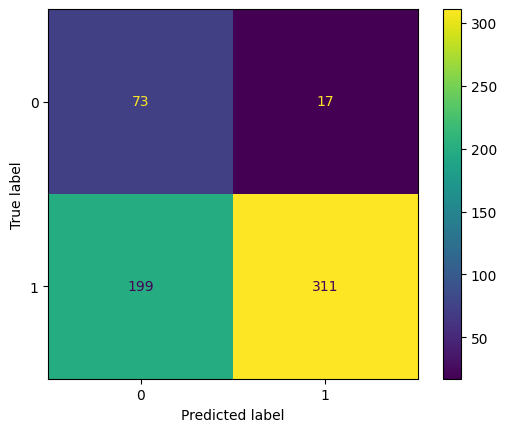


               precision    recall  f1-score   support

           0       0.27      0.81      0.40        90
           1       0.95      0.61      0.74       510

    accuracy                           0.64       600
   macro avg       0.61      0.71      0.57       600
weighted avg       0.85      0.64      0.69       600

Sensitivity: 0.61 Specificity: 0.811 Precision: 0.846 ROC_AUC_SCORE: 0.782



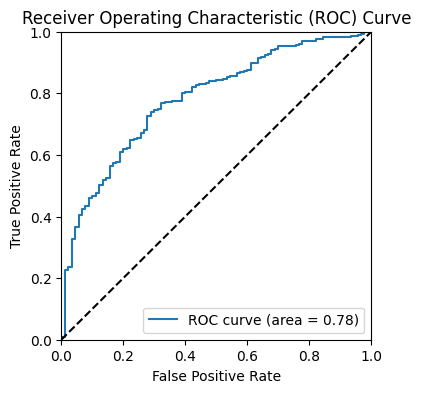

Testing Complete
Test using model 2
600/600 [==============================] - 28s 47ms/step


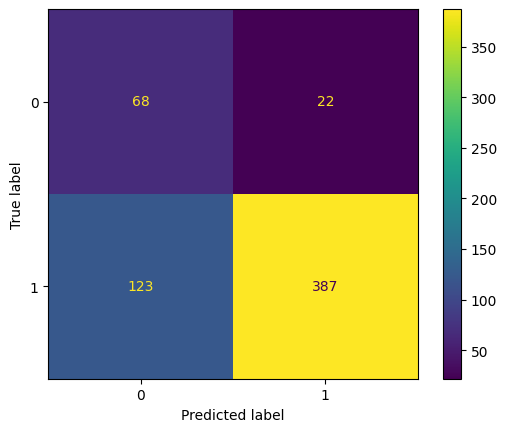


               precision    recall  f1-score   support

           0       0.36      0.76      0.48        90
           1       0.95      0.76      0.84       510

    accuracy                           0.76       600
   macro avg       0.65      0.76      0.66       600
weighted avg       0.86      0.76      0.79       600

Sensitivity: 0.759 Specificity: 0.756 Precision: 0.858 ROC_AUC_SCORE: 0.851



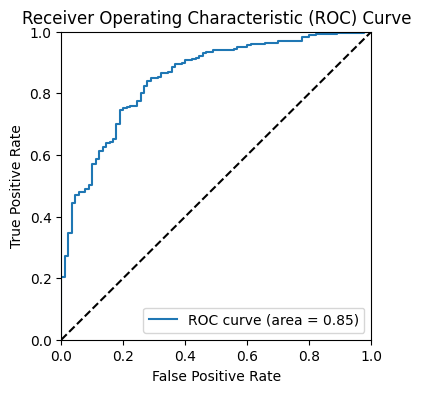

Testing Complete
Test using model 3
600/600 [==============================] - 31s 51ms/step


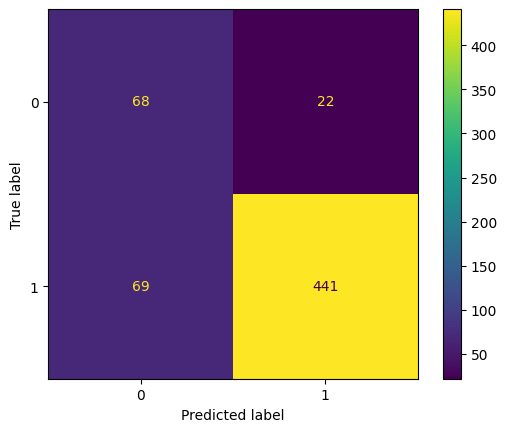


               precision    recall  f1-score   support

           0       0.50      0.76      0.60        90
           1       0.95      0.86      0.91       510

    accuracy                           0.85       600
   macro avg       0.72      0.81      0.75       600
weighted avg       0.88      0.85      0.86       600

Sensitivity: 0.865 Specificity: 0.756 Precision: 0.884 ROC_AUC_SCORE: 0.889



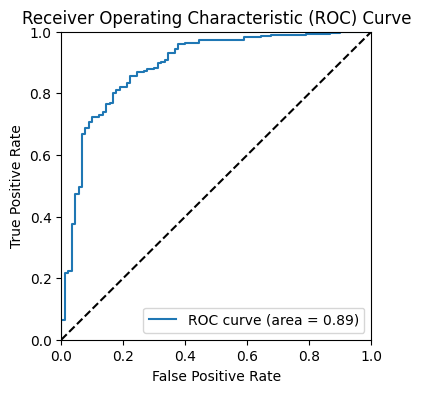

Testing Complete
Test using model 4
600/600 [==============================] - 31s 52ms/step


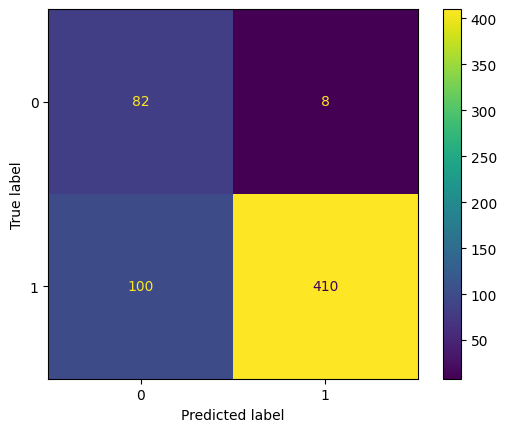


               precision    recall  f1-score   support

           0       0.45      0.91      0.60        90
           1       0.98      0.80      0.88       510

    accuracy                           0.82       600
   macro avg       0.72      0.86      0.74       600
weighted avg       0.90      0.82      0.84       600

Sensitivity: 0.804 Specificity: 0.911 Precision: 0.901 ROC_AUC_SCORE: 0.922



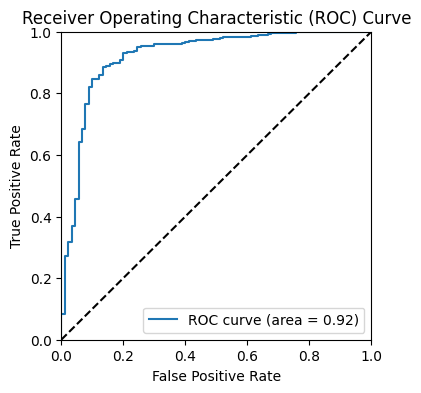

Testing Complete
Test using model 5
600/600 [==============================] - 30s 50ms/step


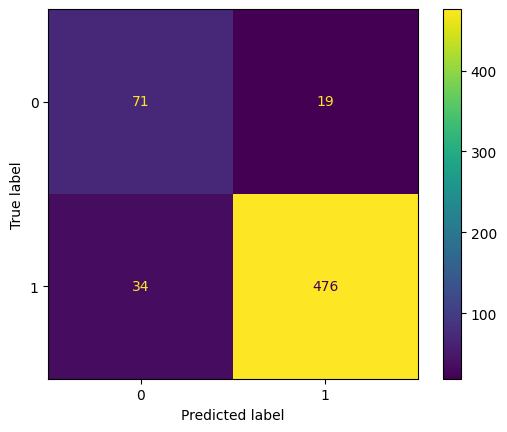


               precision    recall  f1-score   support

           0       0.68      0.79      0.73        90
           1       0.96      0.93      0.95       510

    accuracy                           0.91       600
   macro avg       0.82      0.86      0.84       600
weighted avg       0.92      0.91      0.91       600

Sensitivity: 0.933 Specificity: 0.789 Precision: 0.919 ROC_AUC_SCORE: 0.894



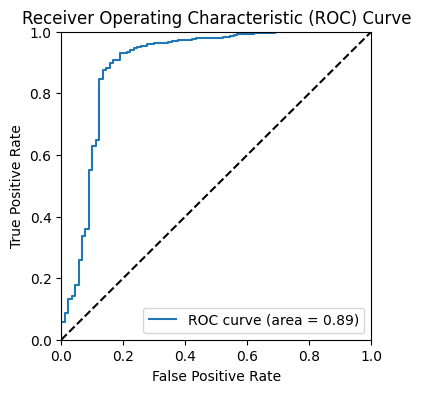

Testing Complete


In [19]:
#set path to best weights from your training please manually! {title}_fold_{fold}
for i in range(1, num_fold+1):
  print(f"Test using model {i}")
  model.load_weights(filepath = model_path + f'/model_fold_{i}.hdf5')
  test_it(model, test_generator)
  print("Testing Complete")